# Import the neccessary libraries

In [43]:
import spacy
import pandas as pd
import numpy as np
import tensorflow as tf
from collections import Counter
import multiprocessing
from gensim.models import Word2Vec
import seaborn as sns

# Import tensorflow module
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers.legacy import Adam

# Import sklearn module
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import utils.data_preprocessing as data_preprocessing
import utils.url_loader as url_loader

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


# Data Processing

## Run to remove duplicates
~~df = data_preprocessing.remove_duplicate(newDfName)~~

"if you omit the duplicates, that will skew the base rate of each distinct object. If the training data are a representative sample of the real world, then you don't want that, because you will actually be training for a slightly different world (one with different base rates)."

In [3]:
#Print the number of rows in the dataset
df = pd.read_csv('./data/balanced_urls.csv')

row_count = df.shape[0]
print(row_count)
display('DataFrame Shape {}'.format(df.shape))

# LSTM 
df_lstm = df.copy()

# K-Means Clustering
df_kmeans = df.copy()

632508


'DataFrame Shape (632508, 3)'

## Dataframe info

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 632508 entries, 0 to 632507
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     632508 non-null  object
 1   label   632508 non-null  object
 2   result  632508 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 14.5+ MB


## Check for NaN Values

In [5]:
df.isnull().sum()

url       0
label     0
result    0
dtype: int64

## Count unique data in 'label' column

In [6]:
df.label.value_counts()

label
benign       316254
malicious    316254
Name: count, dtype: int64

# K-Means Clustering Model Preparation

In [7]:
df_kmeans['url_length'] = df_kmeans['url'].apply(lambda x: len(str(x))) # Get Length of URL
df_kmeans['digits_in_url'] = df_kmeans['url'].apply(lambda x: url_loader.count_digits(x)) # Get Number of Digits in URL
df_kmeans['non_numerical_in_url'] = df_kmeans['url'].apply(lambda x: url_loader.count_nonDigitsAlpahbet(x)) # Get Number of Non-Numeric in URL
df_kmeans['domain_name'] = df_kmeans['url'].apply(lambda x: url_loader.get_domain_name(x)) # Get Domain Name of URL

df_kmeans.head()

,url,label,result,url_length,digits_in_url,non_numerical_in_url,domain_name
0,https://www.google.com,benign,0,22,0,5,www.google.com
1,https://www.youtube.com,benign,0,23,0,5,www.youtube.com
2,https://www.facebook.com,benign,0,24,0,5,www.facebook.com
3,https://www.baidu.com,benign,0,21,0,5,www.baidu.com
4,https://www.wikipedia.org,benign,0,25,0,5,www.wikipedia.org


In [8]:
X_kmeans = df_kmeans
y_kmeans = df_kmeans['result']

X_kmeans_train, X_kmeans_test, y_kmeans_train, y_kmeans_test=train_test_split(X_kmeans,y_kmeans, test_size=0.1, random_state=21)

In [9]:
X_kmeans_train_new = pd.DataFrame()
X_kmeans_train_new['url_length'] = X_kmeans_train['url_length']
X_kmeans_train_new['non_numerical_alphabetical_in_url'] = X_kmeans_train['non_numerical_in_url']
X_kmeans_train_new['digits_in_url'] = X_kmeans_train['digits_in_url']
X_kmeans_train_new['results'] = X_kmeans_train['result']

## Check for missing values
``

In [10]:
X_kmeans_train_new.isna().sum()
missing_cols, missing_rows = (
    (X_kmeans_train_new.isnull().sum(x) | X_kmeans_train_new.eq('').sum(x))
    .loc[lambda x: x.gt(0)].index
    for x in (0, 1)
)
X_kmeans_train_new.loc[missing_rows]

,url_length,non_numerical_alphabetical_in_url,digits_in_url,results


# K-Means Clustering Preparation

In [11]:
X_kmeans = X_kmeans_train_new
X_kmeans = X_kmeans.drop('results', axis=1)
X_kmeans = MinMaxScaler().fit_transform(X_kmeans)
display(X_kmeans)
y_kmeans = X_kmeans_train_new['results']

array([[0.0177259 , 0.04624277, 0.00271003],
       [0.0077821 , 0.03468208, 0.        ],
       [0.02377864, 0.05202312, 0.        ],
       ...,
       [0.04539559, 0.10404624, 0.01897019],
       [0.04712495, 0.13294798, 0.01084011],
       [0.01124081, 0.02312139, 0.00542005]])

In [12]:
kmeans = KMeans(n_clusters=2,init='k-means++',max_iter=300,n_init=10,random_state=42)
kmeans.fit(X_kmeans)
kmeans.labels_

array([0, 0, 0, ..., 1, 1, 0])

In [13]:
correct_labels = sum(y_kmeans == kmeans.labels_)

print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y_kmeans.size))

print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y_kmeans.size)))

Result: 315770 out of 569257 samples were correctly labeled.
Accuracy score: 0.55


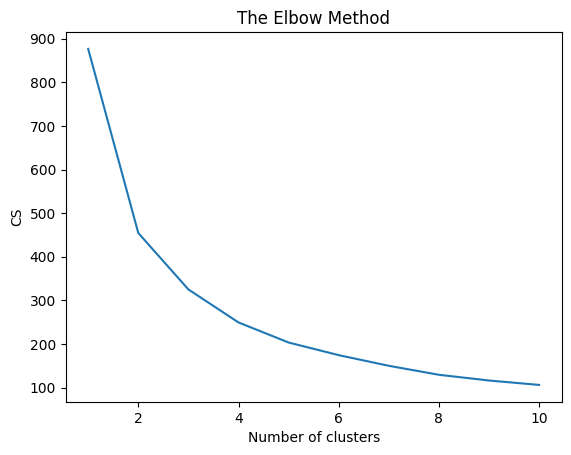

In [14]:
cs = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X_kmeans)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

In [15]:
X_kmeans_test = X_kmeans_test.drop('url', axis=1)
X_kmeans_test = X_kmeans_test.drop('label', axis=1)
X_kmeans_test = X_kmeans_test.drop('result', axis=1)
X_kmeans_test = X_kmeans_test.drop('domain_name', axis=1)
y_kmeans_predict = kmeans.predict(X_kmeans_test)

# print(y_kmeans_predict)

c:\Users\garet\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [16]:
correct_labels = sum(y_kmeans_test == y_kmeans_predict)

print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y_kmeans_test.size))

print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y_kmeans_test.size)))

Result: 0 out of 63251 samples were correctly labeled.
Accuracy score: 0.00


# LSTM Model Preparation

## Tokenizing the URL - Word2Vec                        

In [17]:
# Initialize list
txt = [url_loader.tokenize_url_regex(word) for word in df_lstm['url']]
# print(txt[:5])
print(len(txt))

# Add tokenized url to new dataset to feed to word2vec model
df_lstm['tokenized_url'] = txt

632508


## Building Word2Vec Model

In [18]:
# Get number of cores
cores = multiprocessing.cpu_count()

# Initialize Word2Vec Model
word2vec_model = Word2Vec(
    min_count = 2,
    vector_size=32,
    window=10,
    workers=1
)

In [19]:
# Build the Word2Vec Vocabulary Corpus
word2vec_model.build_vocab(txt, progress_per=10000)

In [20]:
# Train the Word2Vec Model
word2vec_model.train(txt, total_examples=len(txt), epochs=10, report_delay=1)

(19802241, 35939220)

## Get Vocab Size, Input Length, and Embedding Size

In [21]:
# Get Vocab Size
vocab=word2vec_model.wv
vocab_size=len(vocab)
print(f"The number of vocab: {vocab_size}")

The number of vocab: 128153


In [22]:
# Get Keys from Word2Vec Model
vocab_keys=list(vocab.index_to_key)

In [23]:
# Create External Dictionary to store Key-Value Pairs
word_vec_dict={}
for words in vocab_keys:
    word_vec_dict[words]=vocab.get_vector(words)
print(f"Number of key-value pairs {len(word_vec_dict)}")

Number of key-value pairs 128153


In [24]:
# Get Maximum Length of Tokenized URL
maxi=-1
for i, rev in enumerate(df_lstm['tokenized_url']):
    if(len(rev)>maxi):
        maxi=len(rev)
print(maxi)

59


In [27]:
# Create a Index to Word Mapping for the Tokenized URLs
tok = Tokenizer()
tok.fit_on_texts(df_lstm['tokenized_url'])
vocab_size = len(tok.word_index) + 1
encd_rev = tok.texts_to_sequences(df_lstm['tokenized_url'])

In [28]:
# Initialize Input Length and Embedding Size
max_url_len = maxi+1 #(60)
embed_dim=32

In [29]:
# Ensure all URL sequence has the same length which is the maximum length of the tokenized url
pad_rev=pad_sequences(encd_rev, maxlen=max_url_len, padding="post")
pad_rev.shape

(632508, 60)

In [30]:
# Creating a Word Embedding Matrix to be passed onto the Embedding Layer of the Deep Learning model
embed_matrix=np.zeros(shape=(vocab_size,embed_dim))
for word, i in tok.word_index.items():
    embed_vector=word_vec_dict.get(word)
    if embed_vector is not None:
        embed_matrix[i]=embed_vector
# print(embed_matrix[3])

# LSTM Model Building and Training

In [31]:
# Initialize the y axis
y_lstm = df_lstm['result']

# Splitting the dataset into train and test dataset
X_lstm_train, X_lstm_test, y_lstm_train, y_lstm_test=train_test_split(pad_rev,y_lstm, test_size=0.1, random_state=21)

In [32]:
# Initialize the LSTM MODEL

from tensorflow.keras.initializers import Constant
# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_url_len, embeddings_initializer=Constant(embed_matrix)))
# lstm_model.add(Flatten())
# lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(32))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(64, activation='relu')) 
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the lstm_model
lstm_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Model summary
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 32)            22027552  
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 22,038,049
Trainable params: 22,038,049
Non-trainable params: 0
_________________________________________________________________


In [33]:
history=lstm_model.fit(X_lstm_train, y_lstm_train, epochs=20, batch_size=64, validation_split=0.3)

Epoch 1/20
6227/6227 [==============================] - 172s 26ms/step - loss: 0.4999 - accuracy: 0.7463 - val_loss: 0.4747 - val_accuracy: 0.7619
Epoch 2/20
6227/6227 [==============================] - 162s 26ms/step - loss: 0.4526 - accuracy: 0.8094 - val_loss: 0.4938 - val_accuracy: 0.7877
Epoch 3/20
6227/6227 [==============================] - 163s 26ms/step - loss: 0.3906 - accuracy: 0.8584 - val_loss: 0.3673 - val_accuracy: 0.8790
Epoch 4/20
6227/6227 [==============================] - 161s 26ms/step - loss: 0.3988 - accuracy: 0.8548 - val_loss: 0.3717 - val_accuracy: 0.8748
Epoch 5/20
6227/6227 [==============================] - 163s 26ms/step - loss: 0.3598 - accuracy: 0.8804 - val_loss: 0.3565 - val_accuracy: 0.8829
Epoch 6/20
6227/6227 [==============================] - 162s 26ms/step - loss: 0.3555 - accuracy: 0.8831 - val_loss: 0.3537 - val_accuracy: 0.8850
Epoch 7/20
6227/6227 [==============================] - 162s 26ms/step - loss: 0.3531 - accuracy: 0.8853 - val_loss: 0

lstm_model.save('./LSTM_Model_V2/lstmv2_model.h5')
lstm_model.save_weights('./LSTM_Model_V2/lstmv2_modelWeights')
lstm_model.save_weights('./LSTM_Model_V2/lstmv2_modelWeights.h5')

## Evaluate Model

1977/1977 [==============================] - 10s 5ms/step


<Axes: >

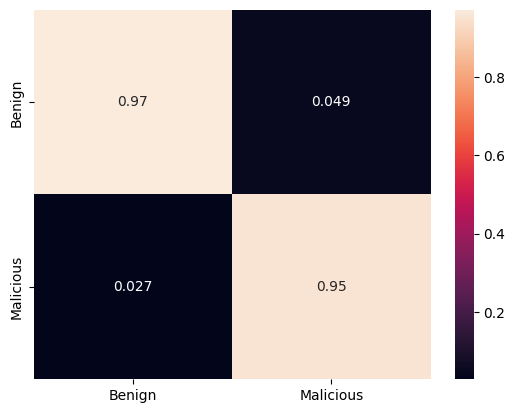

In [42]:
# Predict the values
y_lstm_predict = lstm_model.predict(X_lstm_test).round()

# Create a confusion matrix based on a predicted column
result = confusion_matrix(y_lstm_test, y_lstm_predict, normalize='pred')

# Plot Confusion Matrix
sns.heatmap(result, annot=True, xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
# sns.heatmap()

In [40]:

scores = lstm_model.evaluate(X_lstm_test, y_lstm_test)

[[0.]
 [1.]
 [1.]]
1977/1977 [==============================] - 13s 6ms/step - loss: 0.1388 - accuracy: 0.9618


In [36]:
print(history.params)
print(history.history.keys())

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss =history.history['loss']
val_loss = history.history['val_loss']

{'verbose': 1, 'epochs': 20, 'steps': 6227}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Text(0.5, 1.0, 'Training and Validation Loss')

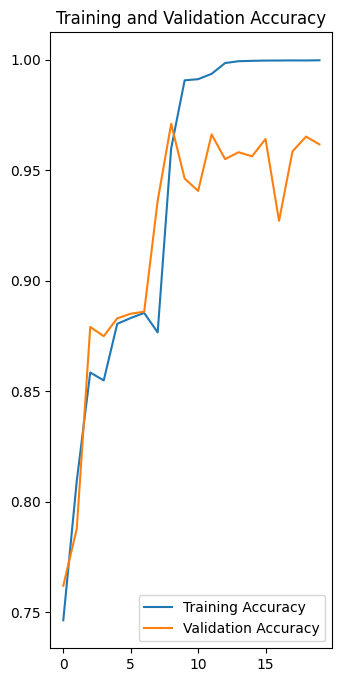

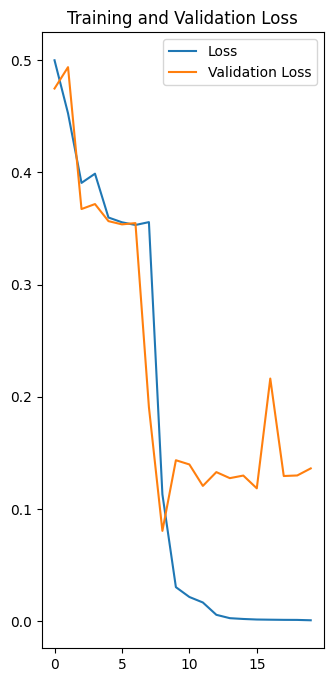

In [37]:
EPOCHS = 20
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), accuracy, label='Training Accuracy')
plt.plot(range(EPOCHS), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label='Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')